This notebook contains all of the analysis that produced the results and figures contained in my paper. It assumes the existence of a folder called 'RAD_data' that should contain the participant_df data frame (given as a .csv) that associates each participant in the study (given a participant_id) with the extracted fMRI features and BIS scores. That dataframe/.csv is created automatically from the feature_extraction iPython Notebook

In [1]:
import nibabel as nib
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.mplot3d import Axes3D
import nilearn as nilearn
from nilearn import plotting, input_data, image
from nilearn.image import mean_img
from nilearn.masking import compute_epi_mask
from nilearn import datasets, plotting, image
from sklearn.feature_extraction import image
from sklearn.cluster import FeatureAgglomeration
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import TSNE
from sklearn import datasets
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.cluster import KMeans
import seaborn as sns
from scipy import stats, integrate
from scipy.stats.mstats import kruskalwallis as kw
import numpy as np
import time as time
import pandas as pd
import statsmodels.api as sm

In order to automatically create legible figure labels, we first establish a system by which we can convert the dataframe-friendly labels into more legible labels.

In [2]:
def convert_cog_circuit_roi_names(names, mapping):

    to_verbose = {
        'DLPFC_left': 'Left Dorsolateral Prefrontal Cortex',
        'DLPFC_right': 'Right Dorsolateral Prefrontal Cortex',
        'precentral_gyrus_left': 'Left Precentral Gyrus',
        'precentral_gyrus_right': 'Right Precentral Gyrus',
        'dACC': 'Dorsal Anterior Cingulate Cortex',
        'dParietal_left': 'Left Dorsal Parietal Cortex',
        'dParietal_right': 'Right Dorsal Parietal Cortex'
    }

    to_abbreviated = {
        'DLPFC_left': 'Left DLPFC',
        'DLPFC_right': 'Right DLPFC',
        'precentral_gyrus_left': 'Left PCG',
        'precentral_gyrus_right': 'Right PCG',
        'dACC': 'dACC',
        'dParietal_left': 'Left DPC',
        'dParietal_right': 'Right DPC',
        'bis_attention_total': 'Attention',
        'bis_motor_total': 'Motor Impulsiveness',
        'bis_selfcontrol_total': 'Self-Control',
        'bis_cogcomplex_total': 'Cognitive Complexity',
        'bis_preserve_total': 'Perserverance',
        'bis_coginstable_total': 'Cognitive Instability',
        'bis_total': 'BIS Total',
        -1: 'Noise',
        0: 'Cluster 1',
        1: 'Cluster 2',
    }
    
    return_values = []
    
    if mapping == 'to_verbose': 
        return [to_verbose[s] for s in names]
    elif mapping == 'to_abbreviated':
        return [to_abbreviated[s] for s in names]
    else:
        print('No such mapping exists: ' + str(mapping))

Next, we create train and test sets by separating the columns in the participant_df data frame into two distinct dataframes with input columns (average beta values at the MNI coordinates) and the output columns (BIS scores), respectively, taking care to ensure that the participant_id's in each row correspond to the right variable values.

In [3]:
path_to_data = 'C:/Users/Scotty/Documents/PanLab/share/leanew1/PANLab_Datasets/RAD_data/'

participant_data = pd.read_csv(path_to_data + 'participant_df_using_cog_circuit_coords.csv')

bis_scores_data = pd.read_csv(path_to_data + 'bis_scores.csv')
bis_individual_labels = ['bis' + str(i) for i in range(1,31)]
old_bis_subtotal_columns = [c for c in bis_scores_data.columns 
               if c not in bis_individual_labels
              and c != 'participant_id']

indx_bis_agg_columns = [x for x in range(0, len(participant_data.columns))
                    if participant_data.columns[x] in old_bis_subtotal_columns]

new_bis_columns = list(participant_data.columns)

for col_name_index in indx_bis_agg_columns:
    old_col_name = participant_data.columns[col_name_index]
    new_col_name = convert_cog_circuit_roi_names(
        [str(old_col_name)], 'to_abbreviated')[0]
    new_bis_columns[col_name_index] = new_col_name

participant_data.columns = new_bis_columns
bis_columns = participant_data.columns[indx_bis_agg_columns]
bis_agg = participant_data[bis_columns]

rois_data = pd.read_csv(path_to_data + 'cog_circuit_coords.csv').T
rois_data.columns = rois_data.loc['brain_region',:]

indx_rois_columns = [x for x in range(0, len(participant_data.columns))
                    if participant_data.columns[x] in rois_data.columns]

new_rois_columns = list(participant_data.columns)

for col_name_index in indx_rois_columns:
    old_col_name = participant_data.columns[col_name_index]
    new_col_name = convert_cog_circuit_roi_names(
        [str(old_col_name)], 'to_abbreviated')[0]
    new_rois_columns[col_name_index] = new_col_name

participant_data.columns = new_rois_columns
rois_columns = participant_data.columns[indx_rois_columns]
rois = participant_data[rois_columns]

X_train, X_test, y_train, y_test = train_test_split(
    participant_data[rois.columns], 
    participant_data[bis_agg.columns], 
    test_size=0.2, 
    random_state=0)

To get a handle on the shape of our output variables/target data, we plot the distribution of our total BIS scores. The shape looks gaussian, as we might expect given that the impulsiveness scores are themselves sums of individual scores on each question in the questionnaire (think Central Limit Theorem)

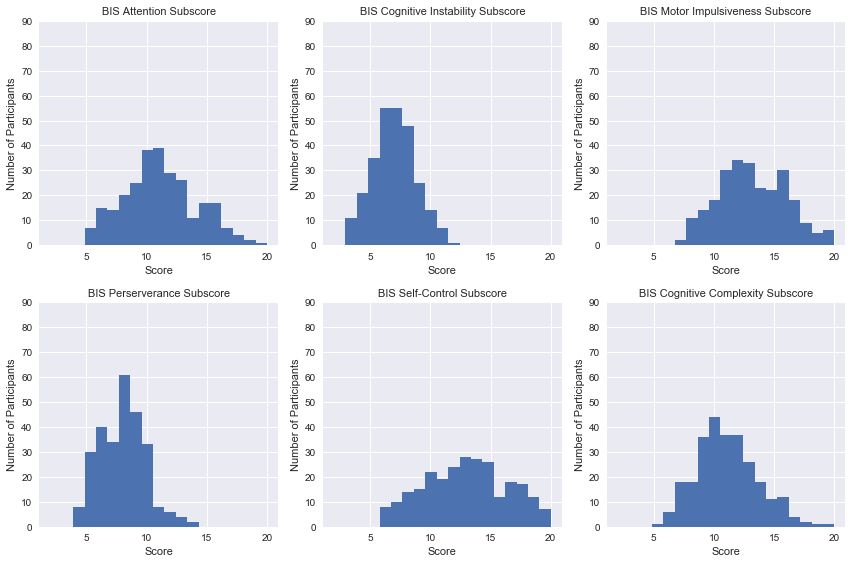

In [4]:
df = y_train[bis_agg.columns]

plt.rcParams['axes.titlesize'] = 11

bins = np.linspace(start=2,stop=20,num=20)
y_upper_lim = 90
y_lower_lim = 0

def to_percent(y, position):
    # Ignore the passed in position. This has the effect of scaling the default
    # tick locations.
    s = str(100 * y)

    # The percent symbol needs escaping in latex
    if matplotlib.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'

plt.figure(1,figsize=(12,8))

plt.subplot(231)
plt.hist(df['Attention'], bins, normed=False)
plt.ylim([y_lower_lim,y_upper_lim])
plt.xlabel('Score')
plt.ylabel('Number of Participants')
plt.title('BIS Attention Subscore')

plt.subplot(232)
plt.hist(df['Cognitive Instability'], bins, normed=False)
plt.ylim([y_lower_lim,y_upper_lim])
plt.xlabel('Score')
plt.ylabel('Number of Participants')
plt.title('BIS Cognitive Instability Subscore')

plt.subplot(233)
plt.hist(df['Motor Impulsiveness'], bins, normed=False)
plt.ylim([y_lower_lim,y_upper_lim])
plt.xlabel('Score')
plt.ylabel('Number of Participants')
plt.title('BIS Motor Impulsiveness Subscore')

plt.subplot(234)
plt.hist(df['Perserverance'], bins, normed=False)
plt.ylim([y_lower_lim,y_upper_lim])
plt.xlabel('Score')
plt.ylabel('Number of Participants')
plt.title('BIS Perserverance Subscore')

plt.subplot(235)
plt.hist(df['Self-Control'], bins, normed=False)
plt.ylim([y_lower_lim,y_upper_lim])
plt.xlabel('Score')
plt.ylabel('Number of Participants')
plt.title('BIS Self-Control Subscore')

plt.subplot(236)
plt.hist(df['Cognitive Complexity'], bins, normed=False)
plt.ylim([y_lower_lim,y_upper_lim])
plt.xlabel('Score')
plt.ylabel('Number of Participants')
plt.title('BIS Cognitive Complexity Subscore')

plt.tight_layout()
plt.show()


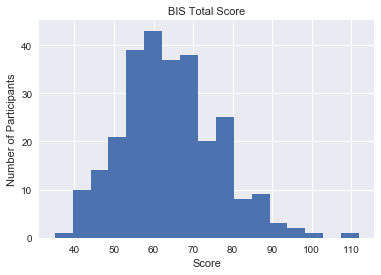

In [5]:
plt.figure(1,figsize=(6,4))
plt.hist(y_train['BIS Total'], bins=17, normed=False)
plt.title('BIS Total Score')
plt.xlabel('Score')
plt.ylabel('Number of Participants')
plt.show()

Similarly, we can plot the data from the ROIs in our training set to get a sense of the distribution of beta-valued ROIs for the participants in our training set.

C:\Users\Scotty\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


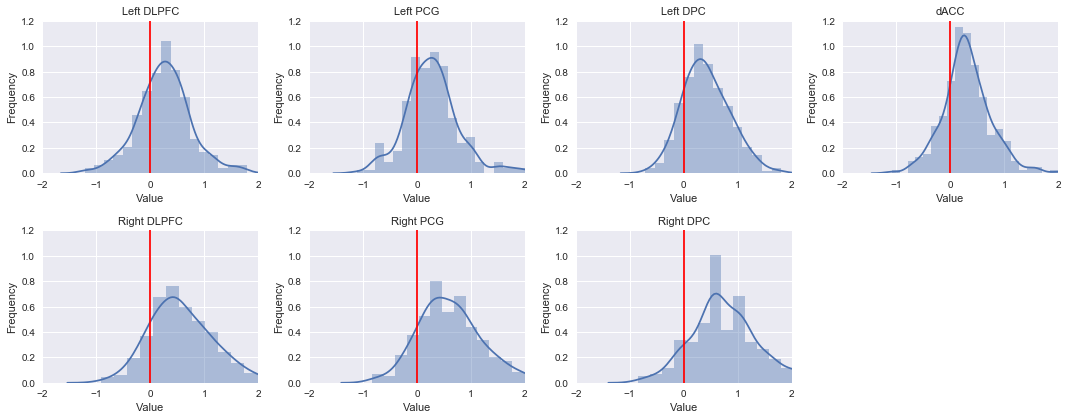

In [6]:
df = X_train[rois.columns]

bins = np.linspace(start=2,stop=20,num=20)

y_lower_lim = 0
y_upper_lim = 1.2

x_lower_lim = -2
x_upper_lim = 2

plt.figure(1,figsize=(15,6))

plt.subplot(241)
sns.distplot(df['Left DLPFC'])
plt.xlim([x_lower_lim, x_upper_lim])
plt.ylim([y_lower_lim, y_upper_lim])
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.axvline(x=0,color='r')
plt.title('Left DLPFC')

plt.subplot(245)
sns.distplot(df['Right DLPFC'])
plt.xlim([x_lower_lim, x_upper_lim])
plt.ylim([y_lower_lim, y_upper_lim])
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.axvline(x=0,color='r')
plt.title('Right DLPFC')

plt.subplot(242)
sns.distplot(df['Left PCG'])
plt.xlim([x_lower_lim, x_upper_lim])
plt.ylim([y_lower_lim, y_upper_lim])
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.axvline(x=0,color='r')
plt.title('Left PCG')

plt.subplot(246)
sns.distplot(df['Right PCG'])
plt.xlim([x_lower_lim, x_upper_lim])
plt.ylim([y_lower_lim, y_upper_lim])
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.axvline(x=0,color='r')
plt.title('Right PCG')

plt.subplot(243)
sns.distplot(df['Left DPC'])
plt.xlim([x_lower_lim, x_upper_lim])
plt.ylim([y_lower_lim, y_upper_lim])
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.axvline(x=0,color='r')
plt.title('Left DPC')

plt.subplot(247)
sns.distplot(df['Right DPC'])
plt.xlim([x_lower_lim, x_upper_lim])
plt.ylim([y_lower_lim, y_upper_lim])
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.axvline(x=0,color='r')
plt.title('Right DPC')

plt.subplot(244)
sns.distplot(df['dACC'])
plt.xlim([x_lower_lim, x_upper_lim])
plt.ylim([y_lower_lim, y_upper_lim])
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.axvline(x=0,color='r')
plt.title('dACC')

plt.tight_layout()
plt.show()

Next, we use dimension reduction techniques like PCA, ICA, and t-SNE on our data set to capture the most salient features present in our input data

In [7]:
"""PCA Dimension Reduction"""

pca = PCA(n_components=3)

pca_train_result = pca.fit_transform(X_train[rois.columns])
X_train['PCA 1'] = pca_train_result[:,0]
X_train['PCA 2'] = pca_train_result[:,1]
X_train['PCA 3'] = pca_train_result[:,2]

pca_test_result = pca.transform(X_test[rois.columns])
X_test['PCA 1'] = pca_test_result[:,0]
X_test['PCA 2'] = pca_test_result[:,1]
X_test['PCA 3'] = pca_test_result[:,2]

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

"""ICA Dimension Reduction"""

ica = FastICA()

ica_train_result = ica.fit_transform(X_train[rois.columns])
ica_train_result /= ica_train_result.std(axis=0)
X_train['ICA 1'] = ica_train_result[:,0]
X_train['ICA 2'] = ica_train_result[:,1]
X_train['ICA 3'] = ica_train_result[:,2]
X_train['ICA 4'] = ica_train_result[:,3]
X_train['ICA 5'] = ica_train_result[:,4]
X_train['ICA 6'] = ica_train_result[:,5]
X_train['ICA 7'] = ica_train_result[:,6]

ica_test_result = ica.transform(X_test[rois.columns])
ica_test_result /= ica_test_result.std(axis=0)
X_test['ICA 1'] = ica_test_result[:,0]
X_test['ICA 2'] = ica_test_result[:,1]
X_test['ICA 3'] = ica_test_result[:,2]
X_test['ICA 4'] = ica_test_result[:,3]
X_test['ICA 5'] = ica_test_result[:,4]
X_test['ICA 6'] = ica_test_result[:,5]
X_test['ICA 7'] = ica_test_result[:,6]

"""t-SNE Dimension Reduction"""

n_sne = 10000

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)

tsne_train_results = tsne.fit_transform(X_train[rois.columns])
X_train['tSNE 1'] = tsne_train_results[:,0]
X_train['tSNE 2'] = tsne_train_results[:,1]

print('{} seconds elapsed'.format(time.time() - time_start))

Explained variation per principal component: [ 0.61133891  0.1435668   0.07985249]
[t-SNE] Computing pairwise distances...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 272 / 272
[t-SNE] Mean sigma: 0.508328
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.567295
[t-SNE] Error after 300 iterations: 1.567295
11.535556077957153 seconds elapsed


With the dimension-reduced data in our train and test data frames, we can visualize the feature space of our data in 2-dimensional images

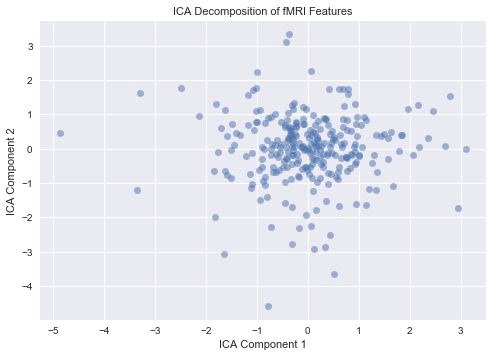

In [8]:
import seaborn as sns

plt.plot(X_train['ICA 1'], X_train['ICA 2'],'o',
        alpha=0.5)
plt.xlabel('ICA Component 1')
plt.ylabel('ICA Component 2')
plt.title('ICA Decomposition of fMRI Features')
plt.show()

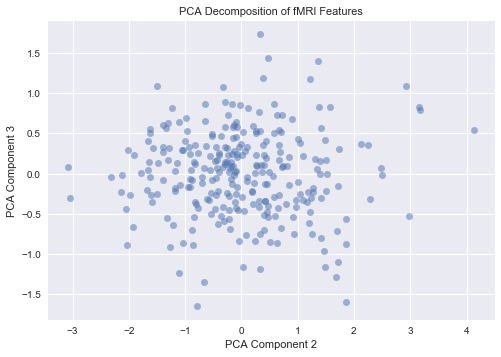

In [9]:
plt.plot(X_train['PCA 1'],X_train['PCA 2'],'o',
        alpha=0.5)
plt.xlabel('PCA Component 2')
plt.ylabel('PCA Component 3')
plt.title('PCA Decomposition of fMRI Features')
plt.show()

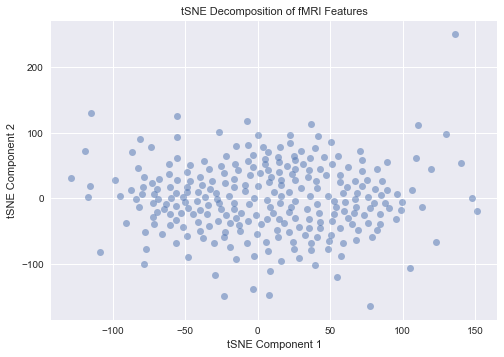

In [10]:
plt.plot(X_train['tSNE 1'],X_train['tSNE 2'],'o',
        alpha=0.5)
plt.xlabel('tSNE Component 1')
plt.ylabel('tSNE Component 2')
plt.title('tSNE Decomposition of fMRI Features')
plt.show()

This function takes in a pandas data frame of input variables, a cluster type, and a dimension reduction method, and gives a 2D plot in dimension-reduced feature space in which each participant's sample is colored according to their cluster label

In [11]:
import seaborn as sns

def plot_with_cluster_labels(X, cluster_type, dimension_reduction_method):
    
    sns.set_style("darkgrid")
    
    fig, ax = plt.subplots()

    colors = {1:'b',2:'g',3:'r',4:'m','Noise':'black',
             'Cluster 1':'b','Cluster 2':'g', 'Cluster 3':'r', 'Cluster 4':'m'}

    grouped = X.groupby(cluster_type + ' Label')
    for key, group in grouped:
        group.plot(ax=ax, kind='scatter', 
                    x=dimension_reduction_method + ' 1',
                    y=dimension_reduction_method + ' 2',
                    label=cluster_type + ' Cluster: ' + str(key),
                  color=colors[key])

    plt.xlabel(dimension_reduction_method + ' Component 1')
    plt.ylabel(dimension_reduction_method + ' Component 2')
    plt.title(dimension_reduction_method + ' Decomposition of fMRI Features with ' + cluster_type + ' clustering')

    plt.legend(frameon=False)
    legend = plt.legend()
    legend.get_frame().set_facecolor('none')
    
    plt.show()

In this code, we run the K-Means Clustering algorithm for a range of different number of clusters and puts the results in a data frame that can then be queried to obtain the number of clusts corresponding to the best Silhouette Score

In [12]:
X = X_train[rois.columns]

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9]

kmeans_cluster_result = []

for n_clusters in range_n_clusters:
    
    num_cluster_specific_result = []
    
    for num_iter in range(20):
    
        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)

        # Compute the silhouette scores for each sample
        num_cluster_specific_result.append(silhouette_score(X, cluster_labels))
    
    kmeans_cluster_result.append(num_cluster_specific_result)

kmeans_cluster_result_df = pd.DataFrame(kmeans_cluster_result).T
kmeans_cluster_result_df.columns = range_n_clusters

Next, we print out the number of clusters vs. average silhouette score to visualize how the number of clusters affects the quality of clustering on our data set

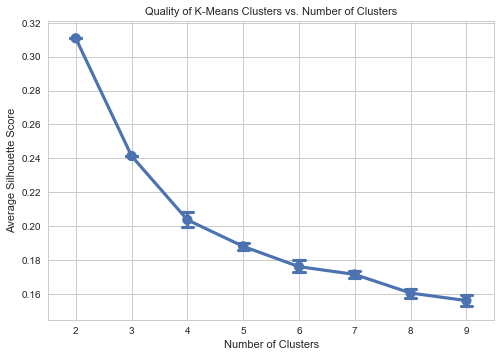

# of Clusters vs Mean Silhouette Score
2    0.310758
3    0.241439
4    0.203810
5    0.188193
6    0.176241
7    0.171671
8    0.160708
9    0.156259
dtype: float64
# of Clusters vs SE(Mean Silhouette Score)
2    1.708597e-16
3    5.695324e-17
4    1.030540e-02
5    5.087153e-03
6    8.356543e-03
7    4.371533e-03
8    6.351851e-03
9    7.489263e-03
dtype: float64


In [13]:
sns.set_style("whitegrid")
sns.pointplot(data=kmeans_cluster_result_df, capsize=.2)
ax = plt.axes()        
ax.xaxis.grid(True) # vertical lines
plt.xlabel('Number of Clusters')
plt.ylabel('Average Silhouette Score')
plt.title('Quality of K-Means Clusters vs. Number of Clusters')
plt.show()
print('# of Clusters vs Mean Silhouette Score')
print(kmeans_cluster_result_df.mean(axis=0))
print('# of Clusters vs SE(Mean Silhouette Score)')
print(kmeans_cluster_result_df.std(axis=0))

Next, we merge the labels from the best clustering algorithm in our training data set so we can run more advanced analyses incorporating both the inputs and the outputs

In [14]:
train = X_train[rois.columns]
test = X_test[rois.columns]

kmeans = KMeans(init='k-means++', n_clusters=2, n_init=10)
kmeans.fit_predict(train)
X_train['K-Means Label'] = kmeans.labels_
X_train['K-Means Label'] = X_train['K-Means Label'] + 1
X_train['K-Means Label'] = ['Cluster ' + str(i) for i in X_train['K-Means Label'].values]

X_test['K-Means Label'] = kmeans.predict(test)
X_test['K-Means Label'] = X_test['K-Means Label'] + 1
X_test['K-Means Label'] = ['Cluster ' + str(i) for i in X_test['K-Means Label'].values]

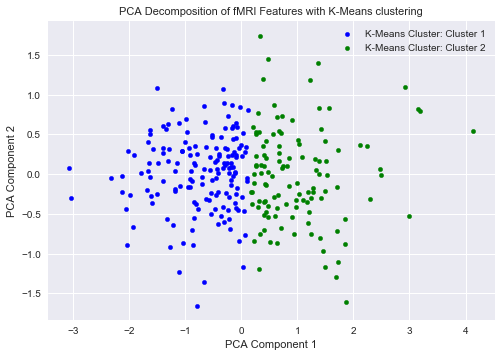

In [15]:
plot_with_cluster_labels(X_train, 'K-Means', 'PCA')

We also explore clustering results using the DBSCAN algorithm

In [16]:
def cluster_with_DBSCAN(X, eps, min_samples, verbose=False):
    
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    
    if verbose:
        print("Epsilon: %0.2f" % eps)
        print("Min Samples: %d" % min_samples)
        print('Estimated number of clusters: %d' % n_clusters_)
    
    if n_clusters_ == 0 or np.all(labels == 0):
        if verbose:
            print("Silhouette Coefficient = -1\n")
        return n_clusters_, -1
    
    else:
        silhouette_score = metrics.silhouette_score(X,labels)
        if verbose:
            print("Silhouette Coefficient: %0.3f\n"
              % silhouette_score)
        return n_clusters_, silhouette_score

The test_all_clusterings algorithm is essentially a wrapper function for cluster_with_DBSCAN that tries a range of different pairs of parameters and stores the results (Average Silhouette Scores) so that we can see how the quality of clustering results differs with parameters we're using

In [17]:
def test_all_clusterings(X, verbose=False):
    
    epsilons = np.arange(start=0.1,stop=1.8,step=0.1)
    min_samples = range(2,11)
    
    DBSCAN_result_vectors = []
    
    for m in min_samples:
        for e in epsilons:
            n_clusters, score = cluster_with_DBSCAN(X, e, m, verbose)
            DBSCAN_result_vectors.append([m, e, n_clusters, score])
    
    result = pd.DataFrame(DBSCAN_result_vectors,
                 columns = ['min_num_neighbors', 'epsilon', 
                            'num_clusters', 'score'])
    
    return result

In [18]:
cluster_result = test_all_clusterings(X_train[rois.columns], verbose=False)

We can plot the results of our DBSCAN clusterings vs parameters to see how varying the parameters affects the quality of our clusterings

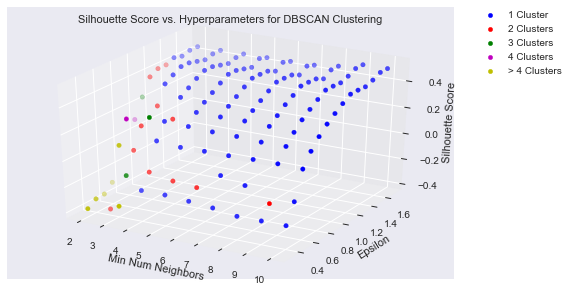

In [19]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111, projection='3d')

eps1 = cluster_result.loc[cluster_result['score'] == 0, 'epsilon']
neighbors1 = cluster_result.loc[cluster_result['score'] == 0, 
                                'min_num_neighbors']
scores1 = cluster_result.loc[cluster_result['score'] == 0, 'score']

eps1 = cluster_result.loc[cluster_result['num_clusters'] == 1, 'epsilon']
neighbors1 = cluster_result.loc[cluster_result['num_clusters'] == 1, 
                                'min_num_neighbors']
scores1 = cluster_result.loc[cluster_result['num_clusters'] == 1, 'score']

eps2 = cluster_result.loc[cluster_result['num_clusters'] == 2, 'epsilon']
neighbors2 = cluster_result.loc[cluster_result['num_clusters'] == 2, 
                                'min_num_neighbors']
scores2 = cluster_result.loc[cluster_result['num_clusters'] == 2, 'score']

eps3 = cluster_result.loc[cluster_result['num_clusters'] == 3, 'epsilon']
neighbors3 = cluster_result.loc[cluster_result['num_clusters'] == 3, 
                                'min_num_neighbors']
scores3 = cluster_result.loc[cluster_result['num_clusters'] == 3, 'score']

eps4 = cluster_result.loc[cluster_result['num_clusters'] == 4, 'epsilon']
neighbors4 = cluster_result.loc[cluster_result['num_clusters'] == 4, 
                                'min_num_neighbors']
scores4 = cluster_result.loc[cluster_result['num_clusters'] == 4, 'score']

eps5 = cluster_result.loc[cluster_result['num_clusters'] >= 5, 'epsilon']
neighbors5 = cluster_result.loc[cluster_result['num_clusters'] >= 5, 
                                'min_num_neighbors']
scores5 = cluster_result.loc[cluster_result['num_clusters'] >= 5, 'score']

ax.scatter(neighbors1,eps1,scores1,c='b',marker='o', label = '1 Cluster')
ax.scatter(neighbors2,eps2,scores2,c='r',marker='o', label = '2 Clusters')
ax.scatter(neighbors3,eps3,scores3,c='g',marker='o', label = '3 Clusters')
ax.scatter(neighbors4,eps4,scores4,c='m',marker='o', label = '4 Clusters')
ax.scatter(neighbors5,eps5,scores5,c='y',marker='o', label = '> 4 Clusters')

ax.set_xlabel('Min Num Neighbors')
ax.set_ylabel('Epsilon')
ax.set_zlabel('Silhouette Score')

plt.title('Silhouette Score vs. Hyperparameters for DBSCAN Clustering')

handles, labels = ax.get_legend_handles_labels()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

sns.set_style("whitegrid")
plt.show()

Using our analysis from above, we extract the best pairs of parameters corresponding to the highest silhouette score

In [20]:
max_score_with_1_clusters = max(cluster_result.loc[
        cluster_result['num_clusters'] == 1, 
        'score'])
best_params_1_dbscan_clusters = cluster_result.loc[cluster_result['score']==max_score_with_1_clusters,
                   ['min_num_neighbors', 'epsilon','score']]

max_score_with_2_clusters = max(cluster_result.loc[
        cluster_result['num_clusters'] == 2, 
        'score'])
best_params_2_dbscan_clusters = cluster_result.loc[cluster_result['score']==max_score_with_2_clusters,
                   ['min_num_neighbors', 'epsilon','score']]

max_score_with_3_clusters = max(cluster_result.loc[
        cluster_result['num_clusters'] == 3, 
        'score'])
best_params_3_dbscan_clusters = cluster_result.loc[cluster_result['score']==max_score_with_3_clusters,
                   ['min_num_neighbors', 'epsilon','score']]

In [21]:
best_params = best_params_2_dbscan_clusters 

X = X_train[rois.columns]

best_epsilon_param = best_params['epsilon'].values[0]
best_min_samples_param = best_params['min_num_neighbors'].values[0]

db = DBSCAN(eps=best_epsilon_param, min_samples=best_min_samples_param).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
X_train['DBSCAN Label'] = labels = db.labels_
X_train['DBSCAN Label'] = X_train['DBSCAN Label'] + 1
X_train.loc[X_train['DBSCAN Label'] == 0, 'DBSCAN Label'] = 'Noise'

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

Estimated number of clusters: 2
Silhouette Coefficient: 0.418


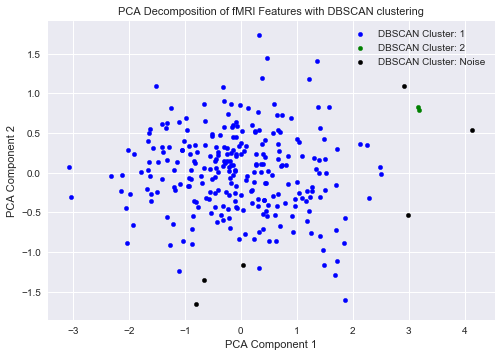

In [22]:
import seaborn as sns

plot_with_cluster_labels(X_train, 'DBSCAN', 'PCA')

Having run both clustering algorithms, we choose to explore the results of the K-Means clustering. In particular, we examine what the distributions of beta values look like for each brain ROI, individually and comparatively

If we view the extracted feature values for each ROI, we can see the two clusters are consistently split along what appears to be the principal axis of variance. This gives the sense of our data as an elongated convex hull in seven-dimensional hull space. It also reinforces the notion that those participants in the study that had higher beta values for one brain region in the Cognitive Circuit typically had higher beta values for all regions in the brain circuit. This supports the concept of the Cognitive Circuit as a true "circuit" that functions as a single unit rather than distinct brain regions

C:\Users\Scotty\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


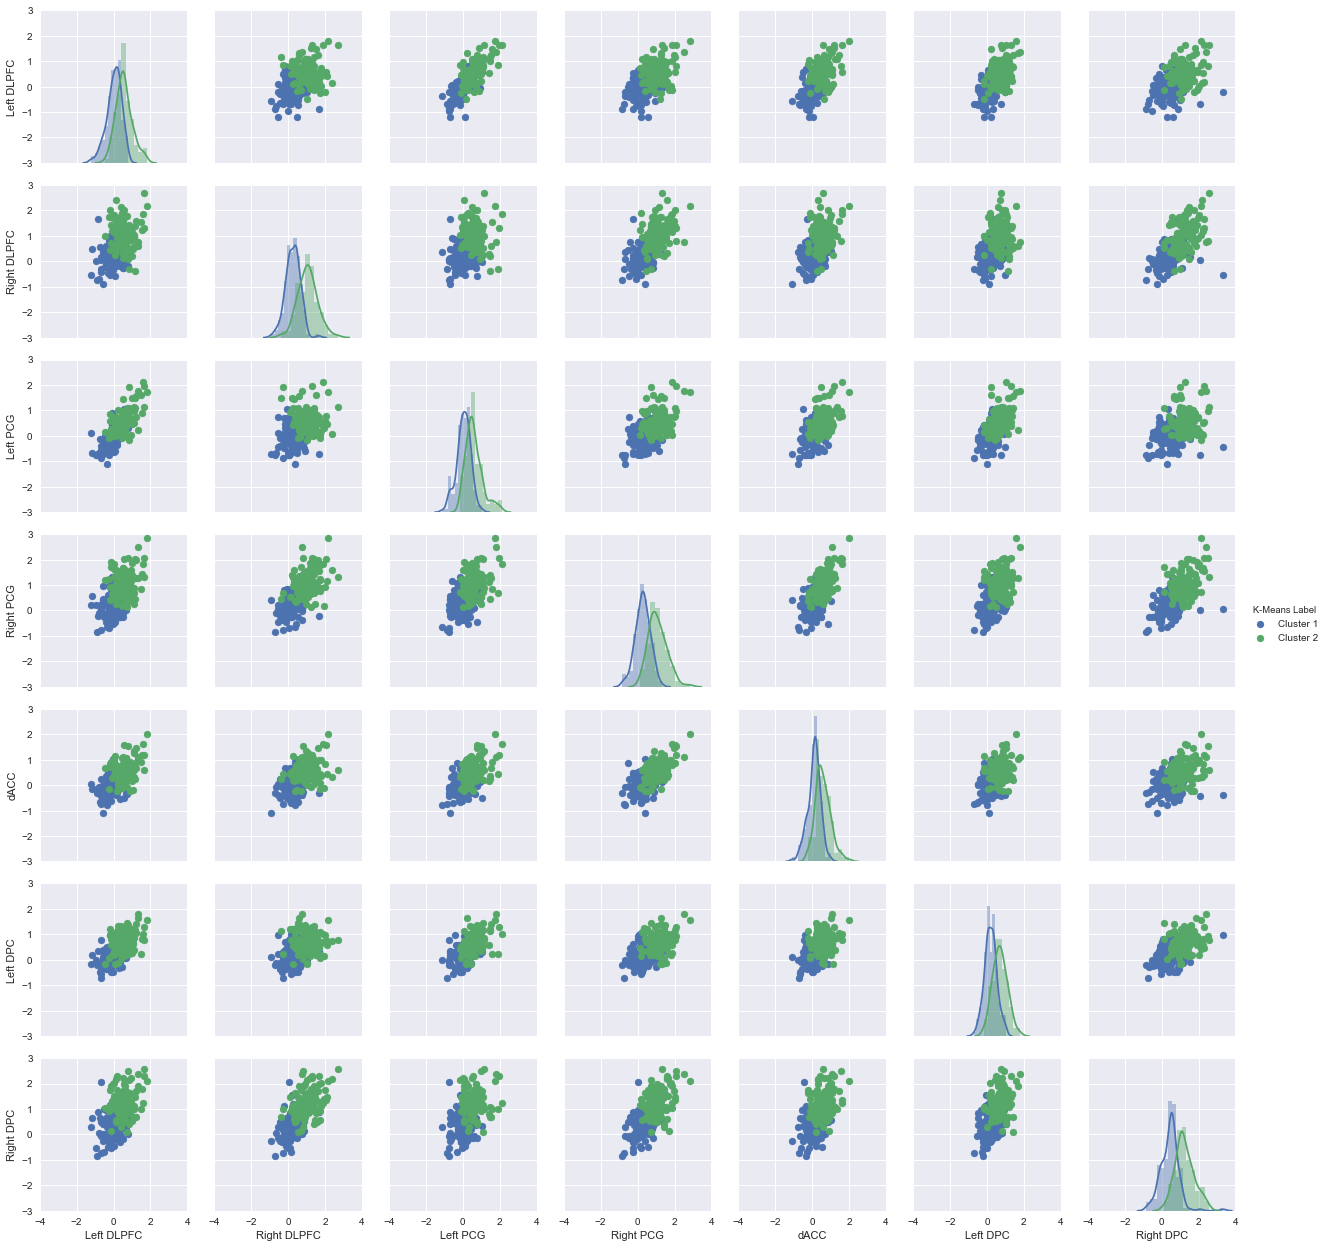

In [25]:
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes, size=10)

graph = sns.PairGrid(X_train[list(rois.columns) + ['K-Means Label']], 
                     hue='K-Means Label')

graph.map_upper(plt.scatter)
graph.map_lower(plt.scatter)
graph.map_diag(sns.distplot)
graph.set(alpha=0.1)
graph.add_legend()

for axes in graph.axes:
    for x in axes:
        x.set_ylim(-3,3)
        x.set_xlim(-4,4)

plt.show()

Additionally, we can examine the distribution of total BIS scores, broken down by K-Means Cluster

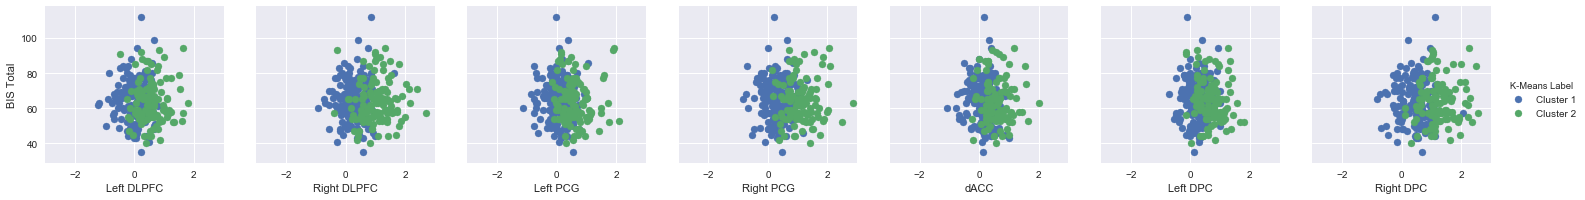

In [23]:
x_cols = list(rois.columns)
y_cols = ['BIS Total']
hue_col = ['K-Means Label']

concatenated = pd.concat([X_train[list(rois.columns) + ['K-Means Label']],y_train[bis_agg.columns]], axis=1, join='inner')

plt.figure()

graph = sns.PairGrid(concatenated[x_cols + y_cols + hue_col],
                        x_vars = x_cols,
                        y_vars = y_cols,
                        hue = hue_col[0],
                        size = 3,
                        aspect = 1)

graph = graph.map(plt.scatter)
graph.set(alpha=0.1)
graph.add_legend()

for axes in graph.axes:
    for x in axes:
        x.set_xlim(-3,3)

plt.show()

C:\Users\Scotty\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


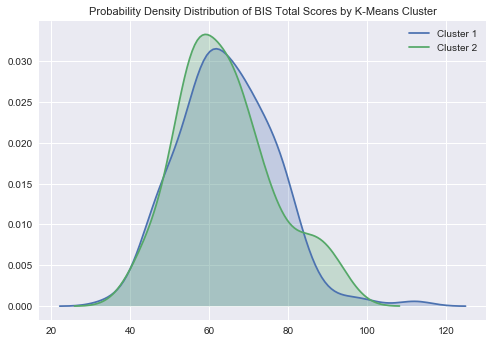

In [24]:
cluster_0_bis_scores = y_train.loc[X_train['K-Means Label'] == 'Cluster 1', 'BIS Total']
cluster_1_bis_scores = y_train.loc[X_train['K-Means Label'] == 'Cluster 2', 'BIS Total']

sns.kdeplot(cluster_0_bis_scores, shade=True, label = 'Cluster 1')
sns.kdeplot(cluster_1_bis_scores, shade=True, label = 'Cluster 2')

plt.title("Probability Density Distribution of BIS Total Scores by K-Means Cluster")
plt.show()

If we run a more rigorous statistical analysis of whether or not a difference in cluster corresponds to any meaningful difference in the BIS total (the Kruskal-Wallis Test) we can confirm that, indeed, there is not sufficient evidence to reject the null hypothesis that the distribution of scores in the clusters are the same. Instead we will try linear regression...

In [26]:
group_1 = y_test.loc[X_test['K-Means Label'] == 'Cluster 1', 'BIS Total']
group_2 = y_test.loc[X_test['K-Means Label'] == 'Cluster 2', 'BIS Total']
kw(group_1, group_2)

KruskalResult(statistic=2.0737142537731486, pvalue=0.14985617570023702)

As a preliminary step to our regression analysis, we examine the correlation between the inputs and the outputs/targets in our data set

In [27]:
import seaborn as sns

def plot_heat_map(X, annot=False):

    corr = X.corr()
    fig, ax = plt.subplots(figsize=(11,9))

    #Generates a diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    #Draws heatmap with mask and correct aspect ratio
    graph = sns.heatmap(corr, cmap=cmap, square=True, 
                linewidths=0.5, ax=ax, annot=annot, vmin=-1, vmax=1)

    plt.rcParams['ytick.labelsize'] = 15
    plt.rcParams['xtick.labelsize'] = 15

    plt.show()

We can examine the correlation of both the inputs and the outputs to get a better idea of potential relationships

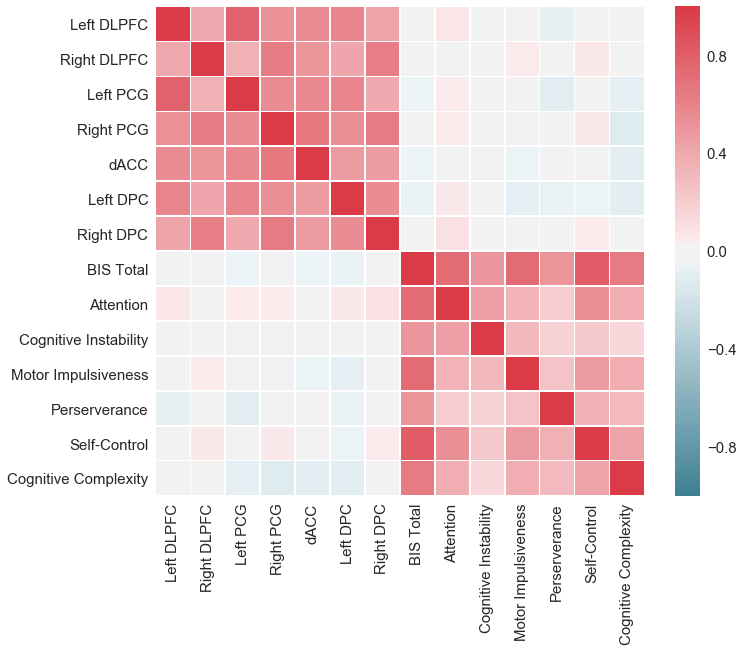

In [29]:
plot_heat_map(pd.concat([X_train[rois.columns],y_train[bis_agg.columns]], axis=1, join='inner'))

If we examine just the correlation among just the inputs, we see that the features are correlated, which is a promising sign that the circuit we're interested in (the Cognitive Circuit) is indeed firing as a single unit. This is a nice sanity check

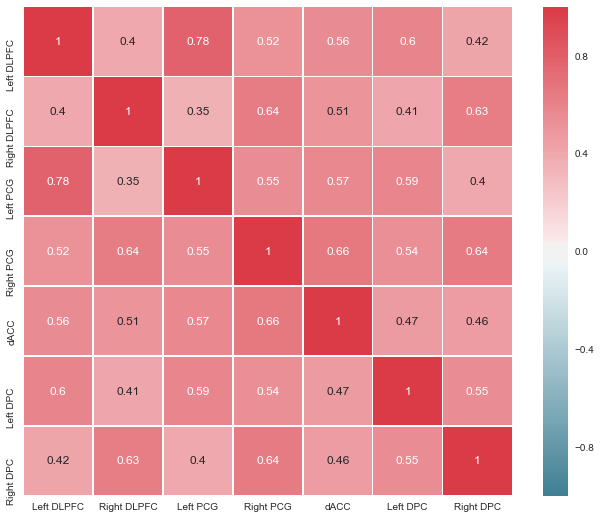

In [28]:
plot_heat_map(X_train[rois.columns],annot=True)

We get perhaps the most meaningful relevant information when we visualize a correlation plot of the inputs against the outputs...

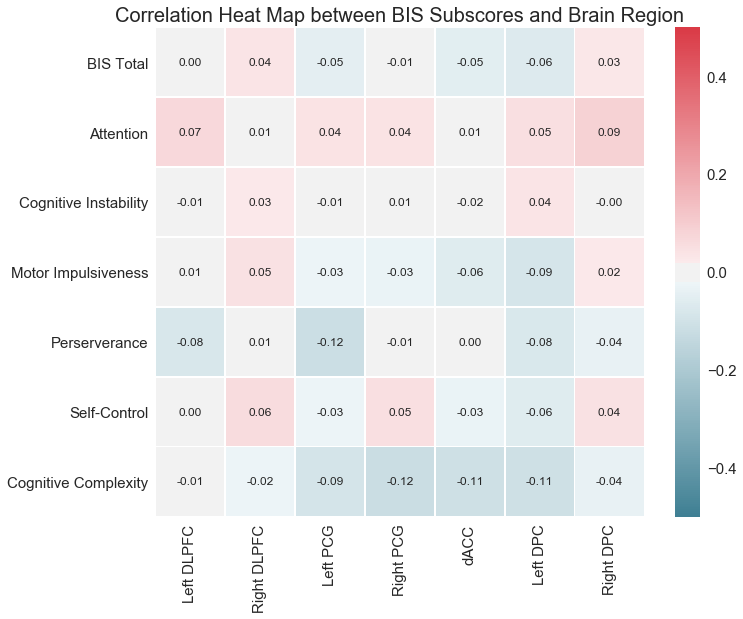

In [30]:
corr = pd.concat([X_train[rois.columns],y_train[bis_agg.columns]], axis=1, join='inner').corr()
corr = corr.loc[list(bis_agg.columns),list(rois.columns)]

fig, ax = plt.subplots(figsize=(11,9))

#Generates a diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

#Draws heatmap with mask and correct aspect ratio
graph = sns.heatmap(corr, cmap=cmap, square=True, 
            linewidths=0.5, ax=ax, annot=True, vmin=-0.5, vmax=0.5, fmt='0.2f')

plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 20

plt.title('Correlation Heat Map between BIS Subscores and Brain Region')

plt.show()

To perform the regression, we first write a function that will automatically choose the regularization rate corresponding to the lowest validation score using 10-fold cross validation

In [31]:
def find_best_reg_rate(X, y, output_path = None):
    alpha_params = np.logspace(-2, 2, 30)
    
    train_scores, valid_scores = validation_curve(
                                            estimator = Lasso(), 
                                            X=X,
                                            y=y,
                                            param_name = "alpha", 
                                            param_range = alpha_params,
                                            scoring="neg_mean_squared_error",
                                            cv=10
                                    )
    valid_scores = -valid_scores.T
    valid_scores_df = pd.DataFrame(valid_scores,
                            index = ['Fold ' + str(i) for i in range(1,11)],
                            columns = alpha_params)
    mean_valid_scores = valid_scores_df.mean(axis=0)
    
    validation_mse_values = mean_valid_scores.values
    
    train_scores = -train_scores.T
    train_scores_df = pd.DataFrame(train_scores,
                            index = ['Fold ' + str(i) for i in range(1,11)],
                            columns = alpha_params)
    mean_train_scores = train_scores_df.mean(axis=0)
    
    best_params = alpha_params[np.where(mean_valid_scores == np.min(mean_valid_scores))]
    best_param = np.min(best_params)
    
    fig,ax = plt.subplots(1)
    plt.xlabel('Regularization Rate')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('Regularization Rate vs. MSE')
    plt.xscale('log')
    ax.plot(alpha_params, mean_valid_scores,color="blue",label="Validation MSE",lw=2)
    ax.plot(alpha_params, mean_train_scores,color="green",label="Training MSE",lw=2)
    plt.axvline(x=best_param,color='r', label = "Best alpha = %.2f" % best_param)
    plt.xscale('log')
    
    handles,labels = ax.get_legend_handles_labels()

    ax.legend(handles,labels,loc=0)
    
    plt.show()

    return best_param

Next, we create a pipeline that will first create polynomial combinations of features with a range of degrees, and then run regression (and associated statistical tests) and plot the results.

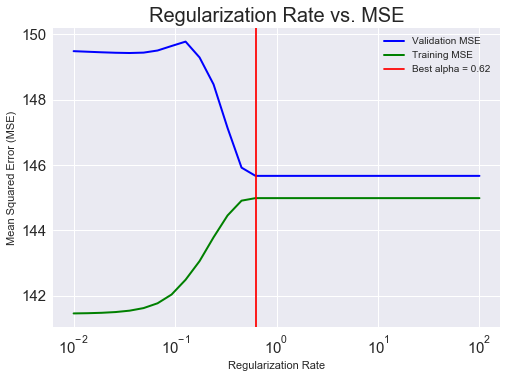


Coefficients:
[(0.0, 'Intercept')]


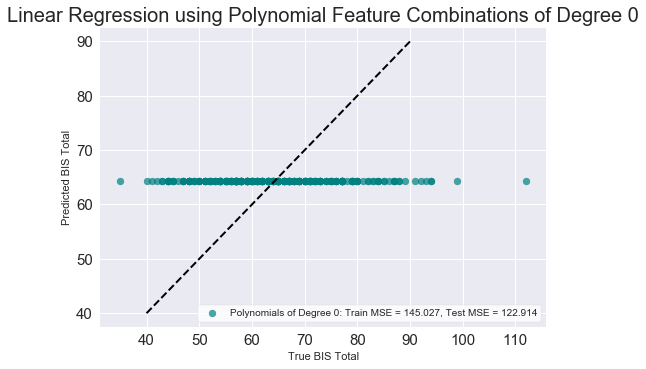


Coefficients:
[(0.0, 'Intercept'), (3.1260364914535654, 'Left DLPFC'), (1.0938814608430665, 'Right DLPFC'), (-1.8774251667266597, 'Left PCG'), (0.27027061085644027, 'Right PCG'), (-2.5609682740843764, 'dACC'), (-3.3102218380904933, 'Left DPC'), (1.3935538560721377, 'Right DPC')]


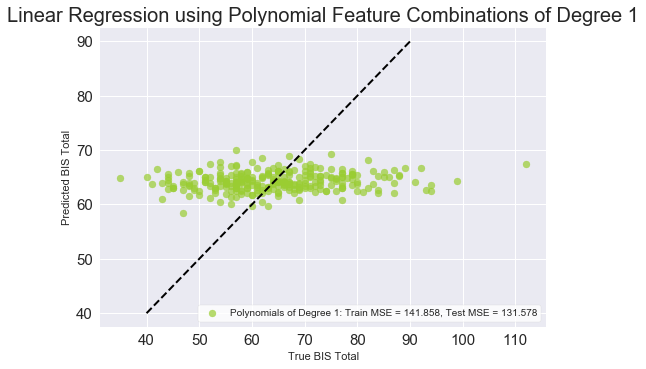


Coefficients:
[(0.0, 'Intercept'), (4.5634910602857435, 'Left DLPFC'), (2.1794551655253884, 'Right DLPFC'), (-5.4123528634330702, 'Left PCG'), (-1.5849985700338207, 'Right PCG'), (-4.2922816942047506, 'dACC'), (0.59325745610445324, 'Left DPC'), (1.7797201733509802, 'Right DPC')]


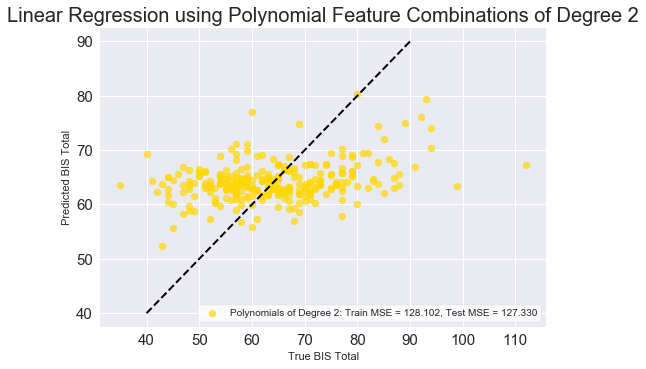


Coefficients:
[(0.0, 'Intercept'), (2.6769503912772619, 'Left DLPFC'), (4.4774377111897703, 'Right DLPFC'), (-5.2545141105922131, 'Left PCG'), (-5.4231147216253852, 'Right PCG'), (-6.178258323587885, 'dACC'), (-2.7570376983590319, 'Left DPC'), (3.0903561568533293, 'Right DPC')]


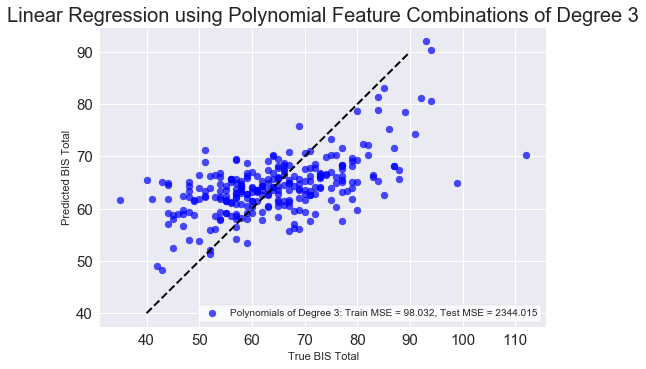

F Statistic Scores:
[(0.006235597157248615, 'Left DLPFC'), (0.37184332393665109, 'Right DLPFC'), (0.61769290530793297, 'Left PCG'), (0.012722785600348282, 'Right PCG'), (0.77351223565828686, 'dACC'), (1.1327538265461694, 'Left DPC'), (0.26146583421454522, 'Right DPC')]

F Statistic p-values:
[(0.93711832002900808, 'Left DLPFC'), (0.54251404480641496, 'Right DLPFC'), (0.43259509332385548, 'Left PCG'), (0.91027664077022064, 'Right PCG'), (0.37991478422190539, 'dACC'), (0.28813959912001397, 'Left DPC'), (0.60953278909002073, 'Right DPC')]

Mutual Information Scores:
[(0.0067658632115437101, 'Left DLPFC'), (0.0, 'Right DLPFC'), (0.0, 'Left PCG'), (0.0, 'Right PCG'), (0.0, 'dACC'), (0.0, 'Left DPC'), (0.0, 'Right DPC')]


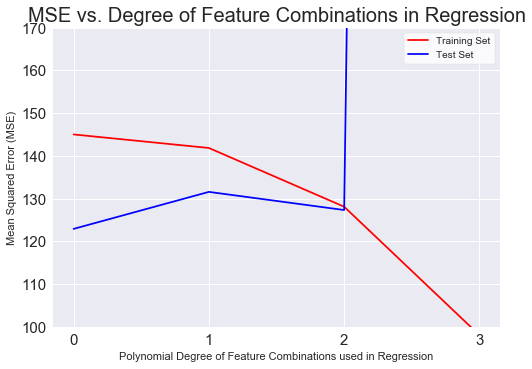

In [33]:
output_column = 'BIS Total'
input_train = X_train[rois.columns].as_matrix()
true_output_train = y_train[output_column].as_matrix()
input_test = X_test[rois.columns].as_matrix()
true_output_test = y_test[output_column].as_matrix()

y_min = 40
y_max = 90

colors = ['teal', 'yellowgreen', 'gold', 'blue']

mse_list = []
poly_degrees = [0,1,2,3]

best_alpha = find_best_reg_rate(input_train, true_output_train)

for count, degree in enumerate([0,1,2,3]):

    pipe = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=best_alpha, 
                                                           fit_intercept=True))
    pipe.fit(input_train, true_output_train)
    predicted_output_train = pipe.predict(input_train)
    predicted_output_test = pipe.predict(input_test)
    
    train_mse = mean_squared_error(true_output_train, predicted_output_train)
    test_mse = mean_squared_error(true_output_test, predicted_output_test)
    
    mse_list.append([degree,train_mse,test_mse])
    
    print('\nCoefficients:\n' + str(list(zip(list(pipe.steps[1][1].coef_), ['Intercept'] +  list(rois.columns)))))
    
    fig, ax = plt.subplots(1)
    plt.scatter(true_output_train, predicted_output_train, color=colors[count],
             label="Polynomials of Degree %d: Train MSE = %.3f, Test MSE = %.3f" % 
                (degree, train_mse, test_mse),
               alpha = 0.7)
    
    handles,labels = ax.get_legend_handles_labels()

    ax.legend(handles,labels,loc='best')

    legend = plt.legend(frameon = 1)
    frame = legend.get_frame()
    frame.set_facecolor('white')

    ax.plot([y_min,y_max], [y_min,y_max], 'k--', lw=2)

    plt.xlabel("True BIS Total")
    plt.ylabel("Predicted BIS Total")
    plt.title("Linear Regression using Polynomial Feature Combinations of Degree %d" % degree)

    plt.show()

f_values, pvals = f_regression(input_train, true_output_train)
print('F Statistic Scores:\n' + str(list(zip(list(f_values), list(rois.columns)))))
print('\nF Statistic p-values:\n' + str(list(zip(list(pvals), list(rois.columns)))))

mi = mutual_info_regression(input_train, true_output_train)
print('\nMutual Information Scores:\n' + str(list(zip(list(mi), list(rois.columns)))))

mse_df = pd.DataFrame(mse_list, columns = ['Polynomial Degree', 'Train MSE', 'Test MSE'])

fig, ax = plt.subplots(1)
plt.plot(mse_df['Polynomial Degree'], mse_df['Train MSE'], 'r', label='Training Set')
plt.plot(mse_df['Polynomial Degree'], mse_df['Test MSE'], 'b', label='Test Set')
plt.xticks(poly_degrees)
plt.xlabel('Polynomial Degree of Feature Combinations used in Regression')
plt.ylabel('Mean Squared Error (MSE)')
plt.ylim(100,170)
plt.title('MSE vs. Degree of Feature Combinations in Regression')

handles,labels = ax.get_legend_handles_labels()

ax.legend(handles,labels,loc='best')

legend = plt.legend(frameon = 1)
frame = legend.get_frame()
frame.set_facecolor('white')

plt.show()